### Importaciones

In [1]:
import sys
import utils
import copy
from naive_bayes import NaiveBayes
import id3

### Lectura de datos "Autism-Adult-Data.arff"

In [2]:
examples = utils.read_file('Autism-Adult-Data.arff')
data_set = examples[0]  # Datos
metadata = examples[1]  # Metadatos

### Constantes

In [3]:
target_attr = 'Class/ASD'
attributes = ['A1_Score', 'A2_Score','A3_Score','A4_Score','A5_Score', 'A6_Score','A7_Score', 'A8_Score','A9_Score',
              'A10_Score','age','gender','ethnicity','jundice','austim','contry_of_res','used_app_before','age_desc',
              'relation']
categorical_atts = ['A1_Score','A2_Score','A3_Score','A4_Score','A5_Score','A6_Score','A7_Score','A8_Score','A9_Score',
                    'A10_Score','gender','ethnicity','jundice','austim','contry_of_res','used_app_before','age_desc',
                    'relation']
non_categorical_atts = ['age']
weight = []
categorical_atts_indexes = [0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18]
non_categorical_atts_indexes = [10]

### Transformación de datos
A continuación se procesan los valores faltantes y se transforman los valores de los atributos a numéricos.<br>
Los valores faltantes se modifican insertando el valor más común del atributo para todos los ejemplos provistos.<br>
La transformación a valores numéricos se realiza utilizando la técnica one hot encoding.

In [4]:
# Se usa most-common para manejar los missing values
data = utils.process_missing_values(data_set, attributes, True)
# Decode bytes
data = utils.decode_data(data)

# Extraemos el target attribute
data_ext, data_target_attributes = utils.extract_target_attributes(data)

# one hot encoding
numeric_data = utils.one_hot_encoding(data_ext, categorical_atts, 
                                      categorical_atts_indexes, non_categorical_atts, 
                                      non_categorical_atts_indexes)
numeric_attributes = list(numeric_data[0].keys())

# Insertamos target attribute
utils.insert_target_attributes(numeric_data, target_attr, data_target_attributes)

### Normalización
Se normalizan los valores numéricos utilizando la técnica de min_max: se re escalan los valores a un rango entre 0 y 1
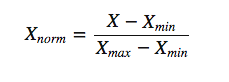
El re escalamiento se ejecuta en tiempo de entrenamiento, y el conjunto de validación se re escala utilizando los mismos parámetros (min y max) que se calcularon previamente.


In [ ]:
#  Se divide el conjunto de datos
numeric_validation_set, numeric_training_set = utils.split_20_80(numeric_data)


# Normalizamos el training set utilizando la tecnica min-max
training_set_scaled, scalation_parameters = utils.scale(copy.deepcopy(numeric_training_set), 
                                                        numeric_attributes,use_standarization)

# Normalizamos el validation set utilizando la tecnica min-max y
# los valores que usamos para normalizar el training
validation_set_scaled = []
for instance in numeric_validation_set:
    scaled_instance = utils.scale_instance(copy.deepcopy(instance), scalation_parameters, use_standarization)
    validation_set_scaled.append(scaled_instance)

### Búsqueda de mejores parámetros iniciales
Se busca el mejor weight y alpha inicial. <br>
Para esto se prueba las combinaciones de weight (vector de n elementos con valor 10, 1, 0.1 y 0, donde n es la cantidad de atributos de los ejemplos), y alpha ∈ {50, 10, 1, 0.5}.<br>
Nos quedamos con la dupla (weight, alpha) que aplicando regresión logística a un conjunto de entrenamiento, luego de 10 ajustes de weight logre el menor valor de la función costo. 

In [5]:
bestChoose = []
posiblesWeight = [10, 1, 0.1, 0]
posiblesAlpha = [50, 10, 1, 0.5]
use_standarization = False


# Se agrega 1 al inicio de los datos para
# que el producto escalar tenga termino sesgo
LR_numeric_attributes = copy.deepcopy(numeric_attributes)
LR_numeric_attributes.insert(0,'sesgo')
LR_training_set_scaled = copy.deepcopy(training_set_scaled)
utils.insert_sesgo_one(LR_training_set_scaled)

# Se inicializa el costo mínimo como inf (máximo float)
minCost = float('inf')

for w in range(4):
    for a in range(4):
        weight= []
        
        # Array de Weights para LR
        for i in range(len(LR_numeric_attributes)):
            weight += [posiblesWeight[w]]

        # Constante alpha de LR
        alpha = posiblesAlpha[a]

        for i in range(10):
            # Se ajusta Weight con decenso por gradiente 10 veces
            weight = utils.descentByGradient(weight, LR_training_set_scaled, alpha, LR_numeric_attributes, target_attr)

        cost = utils.costFunction(weight, LR_training_set_scaled, LR_numeric_attributes, target_attr)

        if (minCost > cost):
            minCost = cost
            bestChoose = [posiblesWeight[w], posiblesAlpha[a], cost]

print("El menor costo conseguido fue: ", bestChoose[2], " con Weight = ", bestChoose[0], " y alpha = ", bestChoose[1])


El menor costo conseguido fue:  0.013247183718368347  con Weight =  0.1  y alpha =  10


### Regresión lógica y comparación de resultado
A continuacion se realizan 10 iteraciones de los algoritmos regresión lógica, KNN, Naive Bayes y ID3 entrenando con el 80% del conjunto de datos y validando con el 20% restante.
En el caso de regresión lógica se utilizan los parametros encontrados en el segmento de codigo anterior.
Finalmente se presenta la comparativa de promedio de errores de los cuatro algoritmos.

In [9]:
errors_LR_total = 0
errors_KNN_total = 0
errors_NB_total = 0
errors_ID3_total = 0

for iter in range(10):
    # Se divide el conjunto de datos
    numeric_validation_set, numeric_training_set = utils.split_20_80(numeric_data)


    use_standarization = False
    # Normalizamos el training set utilizando la tecnica min-max
    training_set_scaled, scalation_parameters = utils.scale(copy.deepcopy(numeric_training_set), numeric_attributes,use_standarization)


    # Normalizamos el validation set utilizando la tecnica min-max y
    # los valores que usamos para normalizar el training
    validation_set_scaled = []
    for instance in numeric_validation_set:
        scaled_instance = utils.scale_instance(copy.deepcopy(instance), scalation_parameters, use_standarization)
        validation_set_scaled.append(scaled_instance)


    # Se agrega 1 al inicio de los datos para
    # que el producto escalar tenga termino sesgo
    LR_numeric_attributes = copy.deepcopy(numeric_attributes)
    LR_numeric_attributes.insert(0,'sesgo')
    LR_training_set_scaled = copy.deepcopy(training_set_scaled)
    LR_validation_set_scaled = copy.deepcopy(validation_set_scaled)
    utils.insert_sesgo_one(LR_training_set_scaled)
    utils.insert_sesgo_one(LR_validation_set_scaled)

    # Weights para LR
    weight = []
    for i in range(len(LR_numeric_attributes)):
        weight += [bestChoose[0]]

    # Constante alpha de LR
    alpha = bestChoose[1]

    # Costo anterior
    cost = float('inf')

    # La condición de parado son 100 iteraciones o una 
    # diferencia de costos menor a 0.0001
    for i in range(25):
        newCost = utils.costFunction(weight, LR_training_set_scaled, LR_numeric_attributes, target_attr)
        dif =abs(cost - newCost)
        if (iter == 1):
            print("Costo ", i + 1, " en la quinta iteración =  ", newCost)
        if (abs(cost - newCost) < 0.0001):
            break
        cost = newCost
        weight = utils.descentByGradient(weight, LR_training_set_scaled, alpha, LR_numeric_attributes, target_attr)


    # LR holdout validation
    errors_LR = utils.LR_holdout_validation(LR_validation_set_scaled, target_attr, weight, LR_numeric_attributes)
    errors_LR_total += errors_LR


    # KNN holdout validation con k = 3 y usando pesos
    errors_KNN = utils.KNN_holdout_validation(copy.deepcopy(training_set_scaled), copy.deepcopy(validation_set_scaled), target_attr, numeric_attributes, 3, True)
    errors_KNN_total += errors_KNN[1]

    nb_classifier = NaiveBayes(copy.deepcopy(training_set_scaled), numeric_attributes, target_attr)
    errors_NB = nb_classifier.holdout_validation(copy.deepcopy(validation_set_scaled), target_attr)
    errors_NB_total += errors_NB[1]

    tree = id3.ID3_algorithm(training_set_scaled, numeric_attributes, target_attr, True, False)
    errors_ID3 = id3.validation(tree, validation_set_scaled, target_attr)
    errors_ID3_total += errors_ID3

print("Promedio de errores:")
print("LR: ", errors_LR_total/10)
print("KNN: ", errors_KNN_total/10)
print("NB: ", errors_NB_total/10)
print("ID3: ", errors_ID3_total/10)

Costo  1  en la quinta iteración =   0.6574101057487131
Costo  2  en la quinta iteración =   6.597406075232884
Costo  3  en la quinta iteración =   2.893087194372054
Costo  4  en la quinta iteración =   0.05916208373097997
Costo  5  en la quinta iteración =   0.036812370085455674
Costo  6  en la quinta iteración =   0.02836561018826376
Costo  7  en la quinta iteración =   0.023191356490393087
Costo  8  en la quinta iteración =   0.01959277701334258
Costo  9  en la quinta iteración =   0.01675607288258882
Costo  10  en la quinta iteración =   0.014476103356084458
Costo  11  en la quinta iteración =   0.012641017637124538
Costo  12  en la quinta iteración =   0.011169619729703473
Costo  13  en la quinta iteración =   0.009992156751842105
Costo  14  en la quinta iteración =   0.0090485227419845
Costo  15  en la quinta iteración =   0.008288279060800723
Costo  16  en la quinta iteración =   0.007670740237906184
Costo  17  en la quinta iteración =   0.0071640444609188175
Costo  18  en la qu